A simple 2-node simulation demonstration the application of GP-CaKe. Of particular interest are the covariance parameters
that define the constraints on the posterior shape of the causal kernels.

References:
    Ambrogioni, L., Hinne, M., van Gerven, M., & Maris, E. (2017). GP CaKe: Effective brain connectivity with causal kernels,
    pp. 1–10. Retrieved from http://arxiv.org/abs/1705.05603

Last updated on July 6th, 2017.

In [5]:
%matplotlib inline
import numpy as np

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility
import diagnostics

Construction of simulated time series data. Here, we start with a 2-node graph with one connection (with max. strength <connection_strength>).

We create a 4 second time series per node, with a sampling rate of 100 Hz. <ntrials_train> trials are then generated to train the dynamic parameters on, and <ntrials_test> to learn the GP posterior.

In [11]:
p                       = 2
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
connection_strength     = 1.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 200
ntrials_test                                        = 200
simulation                                          = sim.integroDifferential_simulator()

(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params)

Plot a few samples to see the generated time series.

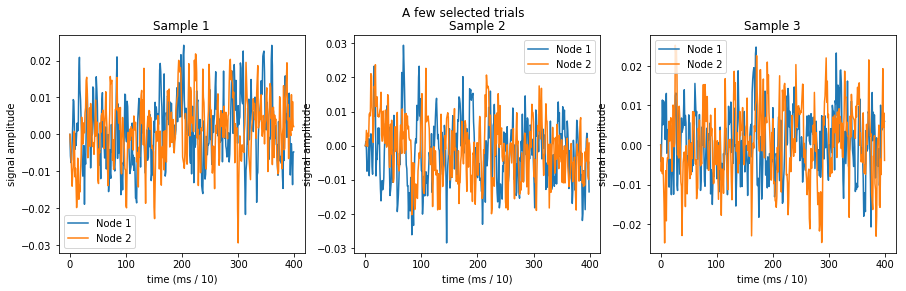

In [12]:
diagnostics.plot_samples(training_samples[0:3])

Simulation is done. Time to bake some cake!

Set up the GP CaKe object and initialize. Currently implemented types of dynamics are 'Relaxation' and 'Oscillation'.

In [13]:
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

Optimize the univariate likelihoods for each node for the dynamic parameters using a grid search.

In [14]:
dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 2
dynamic_parameters_range["relaxation_constant"]["min"] = 20
dynamic_parameters_range["relaxation_constant"]["max"] = 50
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 0.001
dynamic_parameters_range["amplitude"]["min"] = 0.005
dynamic_parameters_range["amplitude"]["max"] = 0.015

cake.learn_dynamic_parameters(training_samples, dynamic_parameters_range)

Set the parameters of the causal kernel.

In [19]:
cake.set_covariance_parameters(time_scale = 0.15,     
                               time_shift = 0.05,      
                               spectral_smoothing = np.pi,
                               number_sources = p,
                               noise_level = 0.05)

Compute the posteriors for each of the p*(p-1) connections.

In [21]:
cake.parallelthreads=1
connectivity = cake.run_analysis(testing_samples)

Visualize the posterior kernels.

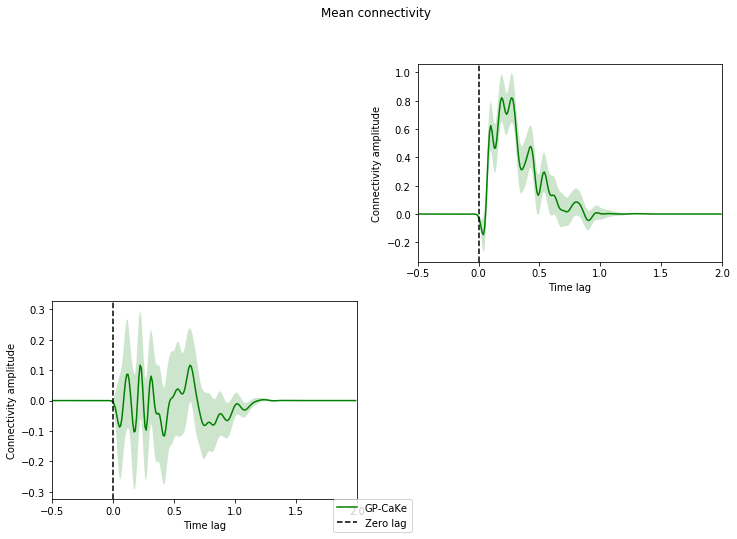

In [22]:
diagnostics.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)